In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [9]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [10]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:

# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in range(int(len(train_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

KeyboardInterrupt: 

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [11]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


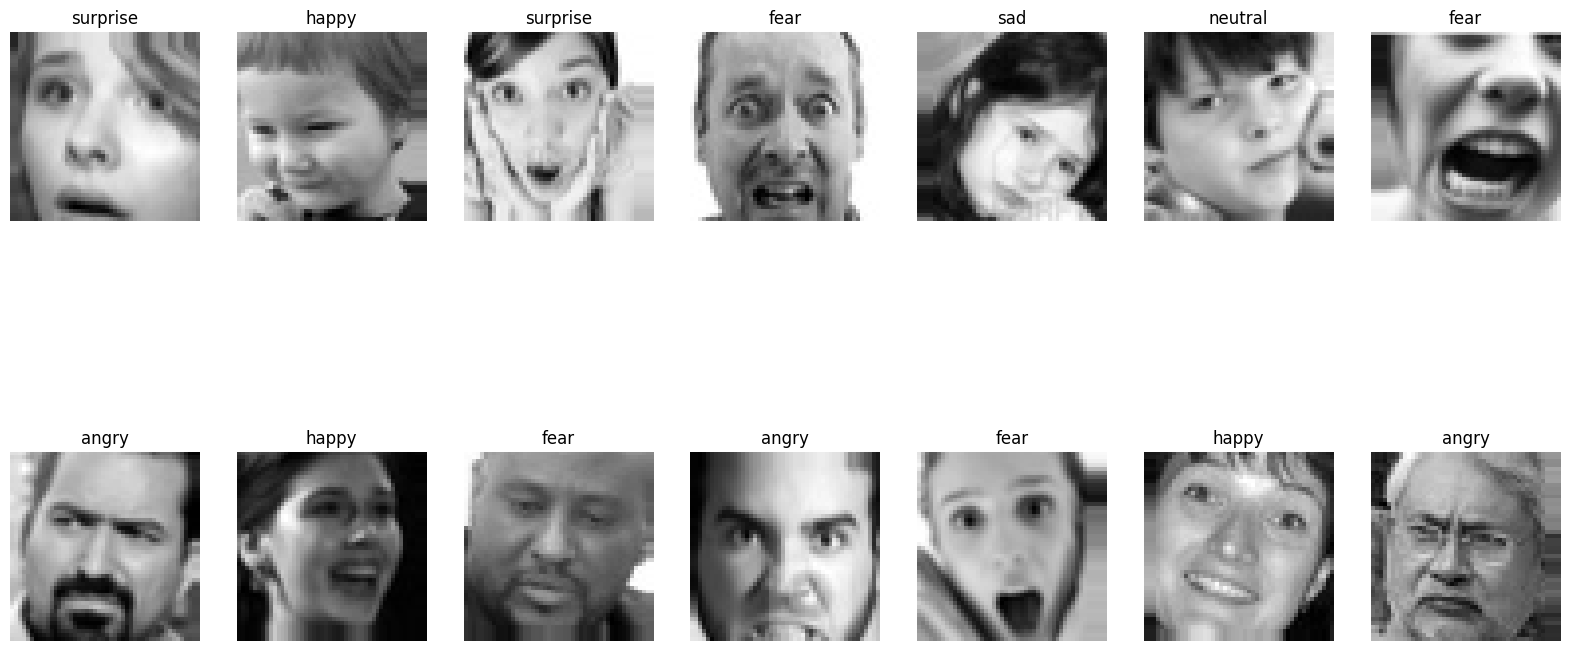

In [12]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [13]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [14]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [15]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [16]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [17]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [18]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [19]:
def light_model(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "light_model")
    return model

In [20]:
model = ResNet34(shape = (48, 48, 1), classes = 7)

epochs = 60
batch_size = 64
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 7, 7, 128)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_11

 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 4, 4, 256)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 4, 4, 256)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_21[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_28 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_31 (Conv2D)             (None, 2, 2, 512)    131584      ['activation_26[0][0]']          
                                                                                                  
 add_13 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_28[0][0]', 
                                                                  'conv2d_31[0][0]']              
                                                                                                  
 activation_28 (Activation)     (None, 2, 2, 512)    0           ['add_13[0][0]']                 
          

In [94]:
light_model =  light_model(shape = (48, 48, 1), classes = 7)
light_model.summary()

Model: "light_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_9 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_10[0][0]']               
 D)                                                                                               
                                                                                                  
 conv2d_289 (Conv2D)            (None, 27, 27, 64)   3200        ['zero_padding2d_9[0][0]']       
                                                                                                  
 batch_normalization_277 (Batch  (None, 27, 27, 64)  256         ['conv2d_289[0][0]']   

 activation_285 (Activation)    (None, 14, 14, 64)   0           ['add_137[0][0]']                
                                                                                                  
 conv2d_298 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_285[0][0]']         
                                                                                                  
 batch_normalization_286 (Batch  (None, 14, 14, 64)  256         ['conv2d_298[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_286 (Activation)    (None, 14, 14, 64)   0           ['batch_normalization_286[0][0]']
                                                                                                  
 conv2d_299 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_286[0][0]']         
          

                                                                  'activation_293[0][0]']         
                                                                                                  
 activation_295 (Activation)    (None, 14, 14, 64)   0           ['add_142[0][0]']                
                                                                                                  
 conv2d_308 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_295[0][0]']         
                                                                                                  
 batch_normalization_296 (Batch  (None, 14, 14, 64)  256         ['conv2d_308[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_296 (Activation)    (None, 14, 14, 64)   0           ['batch_normalization_296[0][0]']
          

                                                                                                  
 add_147 (Add)                  (None, 14, 14, 64)   0           ['batch_normalization_305[0][0]',
                                                                  'activation_303[0][0]']         
                                                                                                  
 activation_305 (Activation)    (None, 14, 14, 64)   0           ['add_147[0][0]']                
                                                                                                  
 conv2d_318 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_305[0][0]']         
                                                                                                  
 batch_normalization_306 (Batch  (None, 14, 14, 64)  256         ['conv2d_318[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_315 (Batch  (None, 14, 14, 64)  256         ['conv2d_327[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_152 (Add)                  (None, 14, 14, 64)   0           ['batch_normalization_315[0][0]',
                                                                  'activation_313[0][0]']         
                                                                                                  
 activation_315 (Activation)    (None, 14, 14, 64)   0           ['add_152[0][0]']                
                                                                                                  
 conv2d_328 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_315[0][0]']         
                                                                                                  
 batch_nor

 conv2d_337 (Conv2D)            (None, 14, 14, 64)   36928       ['activation_324[0][0]']         
                                                                                                  
 batch_normalization_325 (Batch  (None, 14, 14, 64)  256         ['conv2d_337[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_157 (Add)                  (None, 14, 14, 64)   0           ['batch_normalization_325[0][0]',
                                                                  'activation_323[0][0]']         
                                                                                                  
 activation_325 (Activation)    (None, 14, 14, 64)   0           ['add_157[0][0]']                
                                                                                                  
 average_p

In [21]:
model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [22]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = 10,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/10
359/359 [==============================] - 2275s 6s/step - loss: 2.0493 - accuracy: 0.1535 - val_loss: 1.9439 - val_accuracy: 0.2479
Epoch 2/10
359/359 [==============================] - 1755s 5s/step - loss: 1.8631 - accuracy: 0.2509 - val_loss: 1.7975 - val_accuracy: 0.3191
Epoch 3/10
359/359 [==============================] - 1749s 5s/step - loss: 1.7741 - accuracy: 0.3056 - val_loss: 1.9165 - val_accuracy: 0.2367
Epoch 4/10
359/359 [==============================] - 1915s 5s/step - loss: 1.7059 - accuracy: 0.3456 - val_loss: 2.4681 - val_accuracy: 0.2053
Epoch 5/10
359/359 [==============================] - 1694s 5s/step - loss: 1.6575 - accuracy: 0.3551 - val_loss: 1.7406 - val_accuracy: 0.3219
Epoch 6/10
359/359 [==============================] - 1014s 3s/step - loss: 1.5903 - accuracy: 0.3804 - val_loss: 1.6903 - val_accuracy: 0.3561
Epoch 7/10
359/359 [==============================] - 1025s 3s/step - loss: 1.5649 - accuracy: 0.3911 - val_loss: 2.0125 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
light_model.save('light_model.h5')